In [443]:
import pandas as pd
import numpy as np
from make_df import create_df, make_inputs #Custom module here
from naive import naive_fit, get_true_labels #Custom module here
import matplotlib.pyplot as plt

This is a demo of our Hard EM algorithm for survival analysis datasets
with a latent cured subpopulation. We will apply this to a melanoma data set.

STEP 1: DATA PREPARATION

In [444]:
mel = pd.read_csv('melanoma.csv')

In [445]:
mel.head()

,Unnamed: 0,time,status,sex,age,year,thickness,ulcer
0,1,10,3,1,76,1972,6.76,1
1,2,30,3,1,56,1968,0.65,0
2,3,35,2,1,41,1977,1.34,0
3,4,99,3,0,71,1968,2.90,0
4,5,185,1,1,52,1965,12.08,1


For the status column 1 means died from the disease, 2 means alive at then end of study, and 3 means died from unrelated
causes. Use this to make a censoring column as follows:
    
    1 means not censored (label 1)
    2 means censored (label 0)
    3 means cenosred (label 0)

In [446]:
censoring_indicator = mel['status']

In [447]:
censoring_indicator = censoring_indicator.replace(3, 0)

In [448]:
censoring_indicator = censoring_indicator.replace(2, 0)

In [449]:
censoring_indicator.head() #This is a sanity check to see if labelled correctly 

0    0
1    0
2    0
3    0
4    1
Name: status, dtype: int64

In [450]:
mel['status'] = censoring_indicator

In [451]:
mel.head() #Another sanity check

,Unnamed: 0,time,status,sex,age,year,thickness,ulcer
0,1,10,0,1,76,1972,6.76,1
1,2,30,0,1,56,1968,0.65,0
2,3,35,0,1,41,1977,1.34,0
3,4,99,0,0,71,1968,2.90,0
4,5,185,1,1,52,1965,12.08,1


In [452]:
covariates = ['sex', 'age', 'thickness', 'ulcer'] #Omit time, year, and status

In [453]:
mel_covariates = mel[covariates] 

In [454]:
#Now standardize the dataframe column wise 

mel_covariates = 1/mel_covariates.std()*(mel_covariates-mel_covariates.mean()) 

In [455]:
mel_covariates['status'] = censoring_indicator #add back the censoring indicator column

In [456]:
mel_covariates.head() #Sanity check

,sex,age,thickness,ulcer,status
0,1.259824,1.411768,1.297595,1.127628,0
1,1.259824,0.212131,-0.766989,-0.882491,0
2,1.259824,-0.687597,-0.533837,-0.882491,0
3,-0.789890,1.111859,-0.006709,-0.882491,0
4,1.259824,-0.027796,3.095237,1.127628,1


In [472]:
noncensored_proportion = len(mel_covariates[mel_covariates.status==1].index)/len(mel_covariates.index)

noncensored_proportion #This is the fraction of our dataset which is *not* censored.

0.2780487804878049

In [458]:
#Extract censored inputs (status label 0) and noncensored inputs (status label 1) using my own function 

columns = ['status']

censored_inputs = make_inputs(mel_covariates, 0, columns) #extract censored

noncensored_inputs = make_inputs(mel_covariates, 1, columns) #extract noncensored

STEP 2: FEED INTO CUSTOM ALGORITHM

Now that the data has been prepared we can fit it into my algorithm.

In [459]:
fit = naive_fit(censored_inputs, noncensored_inputs, 'use_HardEM')  

In [460]:
y_pred = fit['pred'] #predicted label of the corresponding row 
        
y_scores = fit['prob'] #This is the probability of *not* being cured
    

    

In [461]:
censored_mel = mel_covariates[mel_covariates['status']==0]

noncensored_mel = mel_covariates[mel_covariates['status']==1]

In [462]:
censored_mel.head()

,sex,age,thickness,ulcer,status
0,1.259824,1.411768,1.297595,1.127628,0
1,1.259824,0.212131,-0.766989,-0.882491,0
2,1.259824,-0.687597,-0.533837,-0.882491,0
3,-0.789890,1.111859,-0.006709,-0.882491,0
7,-0.789890,0.452058,0.101420,1.127628,0


In [463]:
final = pd.concat([censored_mel, noncensored_mel]) 

final['predicted_cure_label'] = y_pred

final['predicted_prob'] = y_scores

In [464]:
final[final.predicted_cure_label==0].tail(50)

,sex,age,thickness,ulcer,status,predicted_cure_label,predicted_prob
166,1.259824,0.092167,-0.114837,-0.882491,0,0.0,0.448629
168,1.259824,-1.287415,-0.712925,-0.882491,0,0.0,0.346058
171,-0.789890,-0.567633,-0.878497,-0.882491,0,0.0,0.272617
173,-0.789890,-2.906925,-0.060773,-0.882491,0,0.0,0.278707
175,1.259824,-0.147760,-0.439224,-0.882491,0,0.0,0.407949
176,-0.789890,-1.947215,-0.766989,-0.882491,0,0.0,0.246530
177,-0.789890,0.092167,-0.496667,-0.882491,0,0.0,0.323901
178,-0.789890,-1.407379,-0.766989,-0.882491,0,0.0,0.260002
180,-0.789890,0.452058,-0.439224,-0.882491,0,0.0,0.339714
181,-0.789890,-0.387688,0.209549,-0.882491,0,0.0,0.376073


In [465]:
final[final.predicted_cure_label==1].tail(50)

,sex,age,thickness,ulcer,status,predicted_cure_label,predicted_prob
140,1.259824,0.871931,1.679425,1.127628,0,1.0,0.772816
145,-0.789890,-0.627615,0.101420,1.127628,0,1.0,0.500108
156,1.259824,-0.327706,1.409103,-0.882491,0,1.0,0.591604
161,1.259824,-0.207742,1.081338,-0.882491,0,1.0,0.562288
164,-0.789890,0.332095,0.101420,1.127628,0,1.0,0.531731
167,-0.789890,0.512040,-0.114837,1.127628,0,1.0,0.515277
169,1.259824,0.512040,-0.712925,1.127628,0,1.0,0.545942
172,-0.789890,0.931913,0.101420,1.127628,0,1.0,0.551383
174,1.259824,0.452058,0.648822,1.127628,0,1.0,0.677281
179,1.259824,0.212131,-0.550732,1.127628,0,1.0,0.552800


In [466]:
cured = final[final.predicted_cure_label==0]

not_cured = final[final.predicted_cure_label==1]


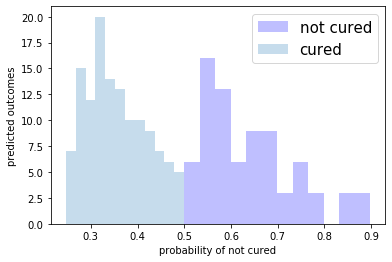

In [467]:
#We plot the predicted cured (not cured) labels on y-axis and the probability of not being cured on the x-axis.
#No surprise here

#Note that we expect a lot of variance with this model even when run multiple times on the same training data, which can 
#seen by how the distribution below changes with different runs.

plt.xlabel('probability of not cured')
plt.ylabel('predicted outcomes')

plt.hist(not_cured['predicted_prob'], bins=12, label='not cured', color='blue', alpha=0.25)
plt.hist(cured['predicted_prob'], bins=12, label='cured', alpha=0.25)
plt.legend(fontsize=15)

plt.show()

In [468]:
y_scores.mean()

0.4634146587153401

In [469]:
y_pred.mean()

0.375609756097561